# Тетрадь 5: Элементарная классификация

## Содержание

- [Введение](#Ввдение)
- [Код и примеры](#Код-и-примеры)
- [Задание](#Задание)

***

## Введение

Классификация — это задача машинного обучения, в которой модель предсказывает категориальную (дискретную) метку для входных данных. Например:
- Определить, является ли email спамом или нет (бинарная классификация).
- Классифицировать изображения по категориям (многоклассовая классификация).

### Основные этапы классификации:
1. **Обучение модели**: На основе обучающих данных модель учится разделять данные на классы.
2. **Предсказание**: Модель присваивает новым данным метку класса на основе выученных закономерностей.

### Математическая основа классификации
Классификация часто сводится к задаче **разделения пространства признаков** на области,
соответствующие разным классам. Для этого используются различные методы:
- **Линейные методы**: Например, логистическая регрессия, которая разделяет данные гиперплоскостью.
- **Нелинейные методы**: Например, метод опорных векторов (SVM) с ядрами, деревья решений или
k-ближайших соседей.

***

## Код и примеры

Перед тем как погрузиться в практическую часть, выполним все необходимые импорты и опрделим
вспомогательную функцию.

In [1]:
from abc import ABC, abstractmethod
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray

from modules.metrics import ConfusionMatrix, compute_confusion_matrix
from modules.preprocessing import DataSplitter


def plot_confusion_matrix(
    confusion_matrix: ConfusionMatrix, title: str
) -> None:
    matrix, _ = confusion_matrix
    figure, axis = plt.subplots()
    ticks = list(range(0, len(matrix)))

    axis.set_yticks(ticks)
    axis.set_xticks(ticks)
    axis.set_xlabel("Actual")
    axis.set_ylabel("Predicted")
    for i, _ in enumerate(matrix):
        for j, _ in enumerate(matrix):
            # fmt: off
            axis.text(
                j, i,
                int(matrix[i, j]),
                verticalalignment="center",
                horizontalalignment="center",
                color="white",
            )
            # fmt: on
    axis.set_title("Confusion Matrix" if title is None else "", fontsize=14)
    to_show = plt.imshow(matrix, cmap="seismic")
    figure.colorbar(to_show, label="Samples")

    plt.tight_layout()
    plt.show()

### Базовый класс моделей

Воспользуемся полезной техникой из тетради 2. Определим абстрактный базовый класс, который будет
описывать устройство модели и сигнатуры её методов.

In [2]:
class ModelBase(ABC):
    """Base machine learning model class."""

    def __init__(self) -> None:
        self.x_train: ndarray
        self.y_train: ndarray

    @abstractmethod
    def fit(self, x_train: ndarray, y_train: ndarray, *args, **kwargs) -> None:
        """The data passed to this method would be copied and used as
        NumPy :class:`ndarray`.
        """
        self.x_train, self.y_train = x_train, y_train

    @abstractmethod
    def predict(self, x_test: ndarray) -> Any:
        message = "Every model should implement the `predict()` method"
        raise NotImplementedError(message)

Образ взаимодействия позаимствован у моделей из Scikit-Learn. В этом фреймворке так же у модели
среди прочих есть два основных метода: `fit()` и `predict()`, которые отвечают за процессы обучения
и прогнозирования соответсвенно.

### Элементарный классификатор

На основе `ModelBase` реализуем теперь свой элементарный классификатор. Допустим, есть всего два
класса (0 и 1) и один признак. Значения признака могут варьироватся от 0 до 1. Если значение
признака больше его стандартного отклонения по обучающим данным, он принадлежит первому классу,
если меньше или равно — второму.

In [3]:
class ElementaryClassifier(ModelBase):
    """Elementary Classifier inherits from Model Base to provide method
    signatures.
    """

    def __init__(self) -> None:
        super().__init__()

    def fit(self, x_train: ndarray, y_train: ndarray, *args, **kwargs) -> None:
        """This method memorizes the training data and calculates the standard
        deviation of the training features.
        """
        super().fit(x_train, y_train)
        self.x_train_std = np.std(self.x_train)

    def predict(self, x_test: ndarray) -> ndarray:
        """This method classifies the data points."""
        pred = list()
        for x in x_test:
            if x > self.x_train_std:
                pred.append(0)
            else:
                pred.append(1)
        pred_arr = np.array(pred)
        return pred_arr

Стоит отметить одну небольшую оптимизацию. Мы всего единажды вычисляем `np.std(self.x_train)`,
вместо того, чтобы каждый раз повторять вычисления в цикле в `predict()`. Потом нужно будет лишь
сравнить данное число с точкой данных в тестовом наборе. На масштабе такая техника позволяет
значительно сократить время прогнозирования.

Посмотрим, как наш классификатор отработает на случайных данных.

In [4]:
random_features = np.random.rand(100, 1)
fstd = np.std(random_features)
classes = np.array([0 if fval > fstd else 1 for fval in random_features])

Не забудем воспользоваться разделителем данных из первого модуля.

In [5]:
splitter = DataSplitter(permute=True)
x_train, x_test, y_train, y_test = splitter.split_data(
    random_features, classes, test_size=0.33
)

Применим `ElementaryClassifier`.

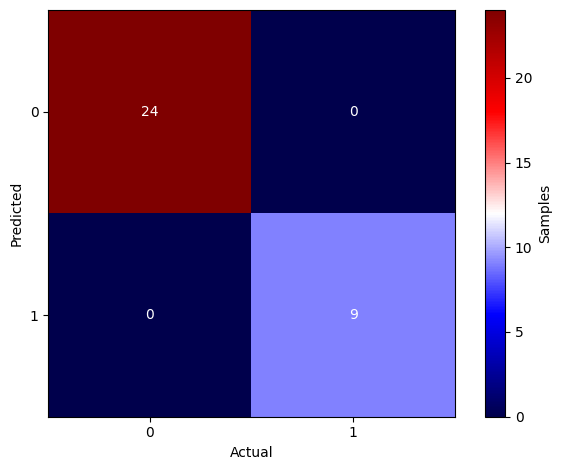

In [6]:
classifier = ElementaryClassifier()

classifier.fit(x_train, y_train)

y_predicted = classifier.predict(x_test)
confusion_matrix = compute_confusion_matrix(
    y_test.reshape((-1, 1)), y_predicted.reshape((-1, 1))
)

plot_confusion_matrix(confusion_matrix, "Elementary Classifier")

Совсем нетрудно заметить, что наш элементарный классификатор успешно справился со своей задачей.
Теперь посмотрим, что будет, если добавить в тестовые данные немного шума.

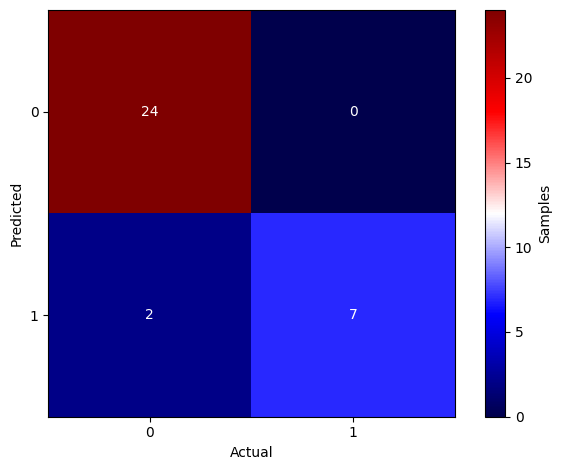

In [7]:
x_test = np.array(
    [fval + 0.1 if fval < 0.9 else fval for fval in x_test.ravel().tolist()]
)

y_predicted = classifier.predict(x_test)
confusion_matrix = compute_confusion_matrix(
    y_test.reshape((-1, 1)), y_predicted.reshape((-1, 1))
)

plot_confusion_matrix(confusion_matrix, "Elementary Classifier with Noise")

Хорошо видно, что теперь модель даёт нам 2 ложно отрицательных значения, так как мы изменили
тестовый набор, и классы теперь не совсем соответсвуют своим признакам.

***

## Задание

Допустим, имеется три класса, у каждого из которых есть три признака. Значение признака находится в
диапазоне от 0 до 1 и является вещественным. Реализуйте модель, которая будет в состоянии присвоить
каждой точке данных правильный класс по следующему правилу:
- если сумма значений признаков в квадрате больше `1`, но меньше или равна `1.5`, точка относится к
первому классу;
- если та же сумма больше `1.5`, точка относится ко второму классу;
- если эта же сумма меньше или равна `1`, точка относится к третьему классу.

Ниже представленны первые 10 строк из набора данных (они уже разделены как нужно).

In [ ]:
ecd = np.load("data/extremely_complex_data.npy")

splitter = DataSplitter(permute=True)
x_train, x_test, y_train, y_test = splitter.split_data(
    ecd[:, :3], ecd[:, 3], test_size=0.33
)

print("Extremely complex data:\n", ecd[:10, :])

In [9]:
class YourExtremelyComplexClassifier(ModelBase): ...

Когда реализуете свой классификатор, выполните ячейку ниже, чтобы оценить его работоспособность.

In [ ]:
classifier = YourExtremelyComplexClassifier()

classifier.fit(x_train, y_train)

y_predicted = classifier.predict(x_test)
confusion_matrix = compute_confusion_matrix(
    y_test.reshape((-1, 1)), y_predicted.reshape((-1, 1))
)

plot_confusion_matrix(confusion_matrix, "Elementary Classifier with Noise")

***

## Выводы

Классификация — это мощный инструмент машинного обучения, который позволяет решать множество
практических задач. Выбор модели зависит от характера данных, объёма выборки и требуемой точности.
KNN, несмотря на свою простоту, остаётся популярным методом, особенно для небольших наборов данных
и задач, где важна интерпретируемость результатов.

В данной тетради мы разобрали устройство базового интерфейса модели и увидили, как и зачем его
использовать. А в следующем notebook'е уже намного более подробно будет изучен алгоритм k-ближайших
соседей с использованием Евклидова расстояния и взвешивания соседей. 